# Завдання

Використовуючи датасет з файлу **cardox.csv (об’єми продажів мережі супермаркетів)** виконайте наступну роботу:

1. Проведіть попередній аналіз даних
2. Скорегуйте виявлені аномалії
3. Проведіть необхідні попередні підготовки даних (декомпозиція, коригування ряду, заповнення пропущених значень і. т. і.)
4. Оберіть модель і проведіть оцінку її метрик
5. Проведіть кінцеву діагностику для отриманої моделі
6. Виконайте прогноз на 30 років
7. Збережіть результати прогнозування у файл

# Розв'язок

In [4]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import ThresholdAD
from adtk.detector import OutlierDetector

from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import variation
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from itertools import compress, product

from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

In [5]:
def sesonal(data, s):
    plt.figure(figsize=(19,8), dpi= 80)
    for i, y in enumerate(data.index.year.unique()):
        plt.plot(list(range(1,len(data[data.index.year==y])+1)), data[data.index.year==y][data.columns[0]].values, label=y)
    plt.title("Сезонність по періодам")
    plt.legend(loc="best")
    plt.show()
    
def metrics(real, forecast):
    
    if type(real)==pd.core.frame.DataFrame:
        real=real[real.columns[0]].values
    
    print("Тест на стаціонарність:")
    dftest = adfuller(real-forecast, autolag='AIC')
    print("\tT-статистика = {:.3f}".format(dftest[0]))
    print("\tP-значення = {:.3f}".format(dftest[1]))
    print("Критичне значення :")
    for k, v in dftest[4].items():
        print("\t{}: {} - Дані {} стационарні з ймовірністю {}% відсотків".format(k, v, "не" if v<dftest[0] else "", 100-int(k[:-1])))
    
    forecast=np.array(forecast)
    print('MAD:', round(abs(real-forecast).mean(),4))
    print('MSE:', round(((real-forecast)**2).mean(),4))
    print('MAPE:', round((abs(real-forecast)/real).mean(),4))
    print('MPE:', round(((real-forecast)/real).mean(),4))
    print('Стандартна похибка:', round(((real-forecast)**2).mean()**0.5,4)) 

In [8]:
df=pd.read_csv("cardox.csv", index_col='date')
df.head()

,value
date,
1958-03-01,315.71
1958-04-01,317.45
1958-05-01,317.50
1958-06-01,317.10
1958-07-01,315.86


In [10]:
df.index = pd.to_datetime(df.index)

[<Axes: >]

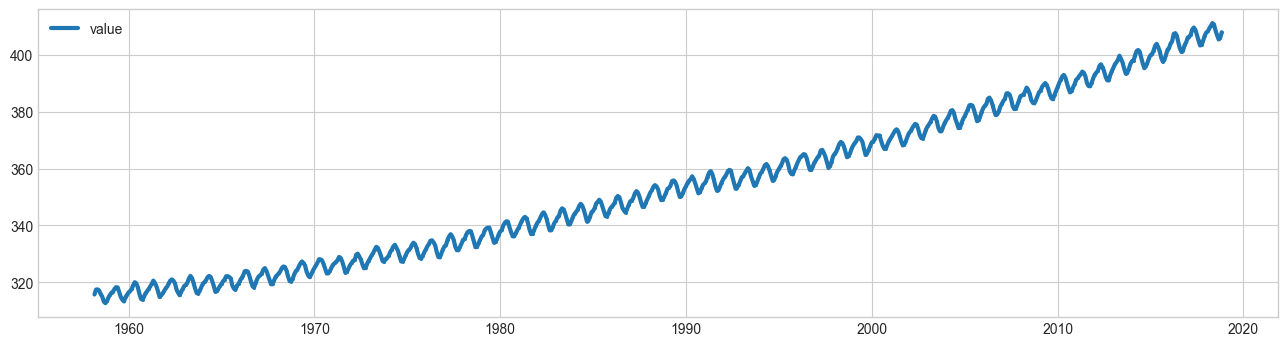

In [11]:
plot(df, ts_linewidth=3)

In [12]:
df.describe()

,value
count,729.000000
mean,353.787229
std,27.547500
min,312.660000
25%,328.570000
50%,351.410000
75%,375.990000
max,411.240000


[<Axes: >]

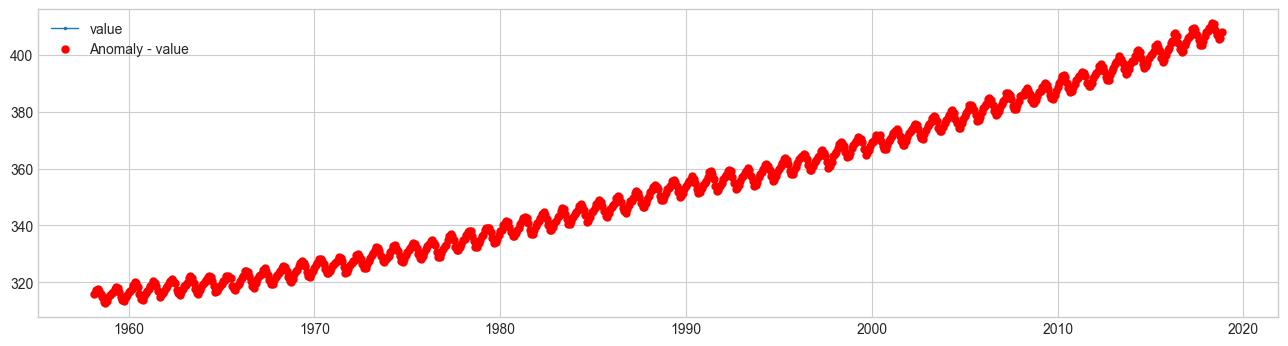

In [14]:
threshold_ad = ThresholdAD(high=2800, low=800)
anomalies = threshold_ad.detect(df)
plot(df, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker")

[<Axes: >]

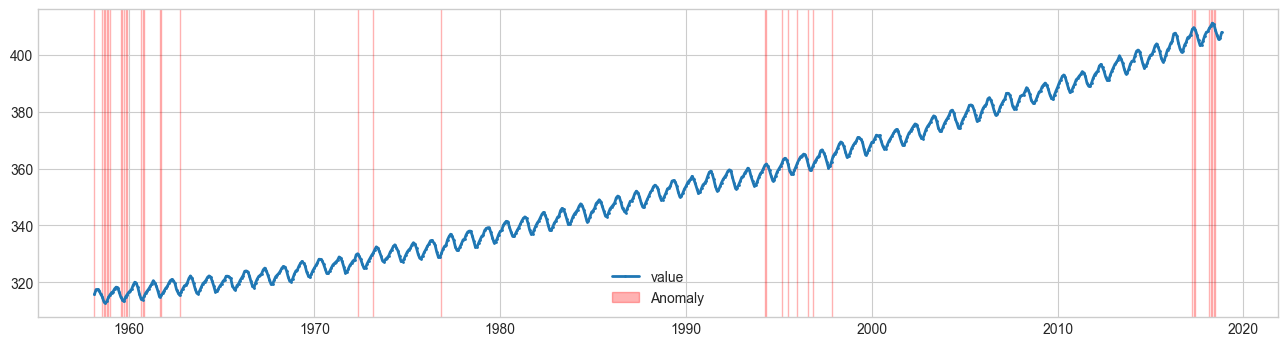

In [15]:
outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.05))
anomalies = outlier_detector.fit_detect(df)
plot(df, anomaly=anomalies, ts_linewidth=2, anomaly_color='red', anomaly_alpha=0.3, curve_group='all')

In [16]:
anomalies[anomalies]

date
1958-03-01    True
1958-08-01    True
1958-09-01    True
1958-10-01    True
1958-11-01    True
1958-12-01    True
1959-01-01    True
1959-08-01    True
1959-09-01    True
1959-10-01    True
1959-11-01    True
1959-12-01    True
1960-09-01    True
1960-10-01    True
1960-11-01    True
1961-09-01    True
1961-10-01    True
1962-10-01    True
1972-05-01    True
1973-03-01    True
1976-11-01    True
1994-04-01    True
1994-05-01    True
1995-03-01    True
1995-07-01    True
1996-01-01    True
1996-08-01    True
1996-11-01    True
1997-11-01    True
2017-04-01    True
2017-05-01    True
2017-06-01    True
2018-03-01    True
2018-04-01    True
2018-05-01    True
2018-06-01    True
2018-07-01    True
dtype: bool

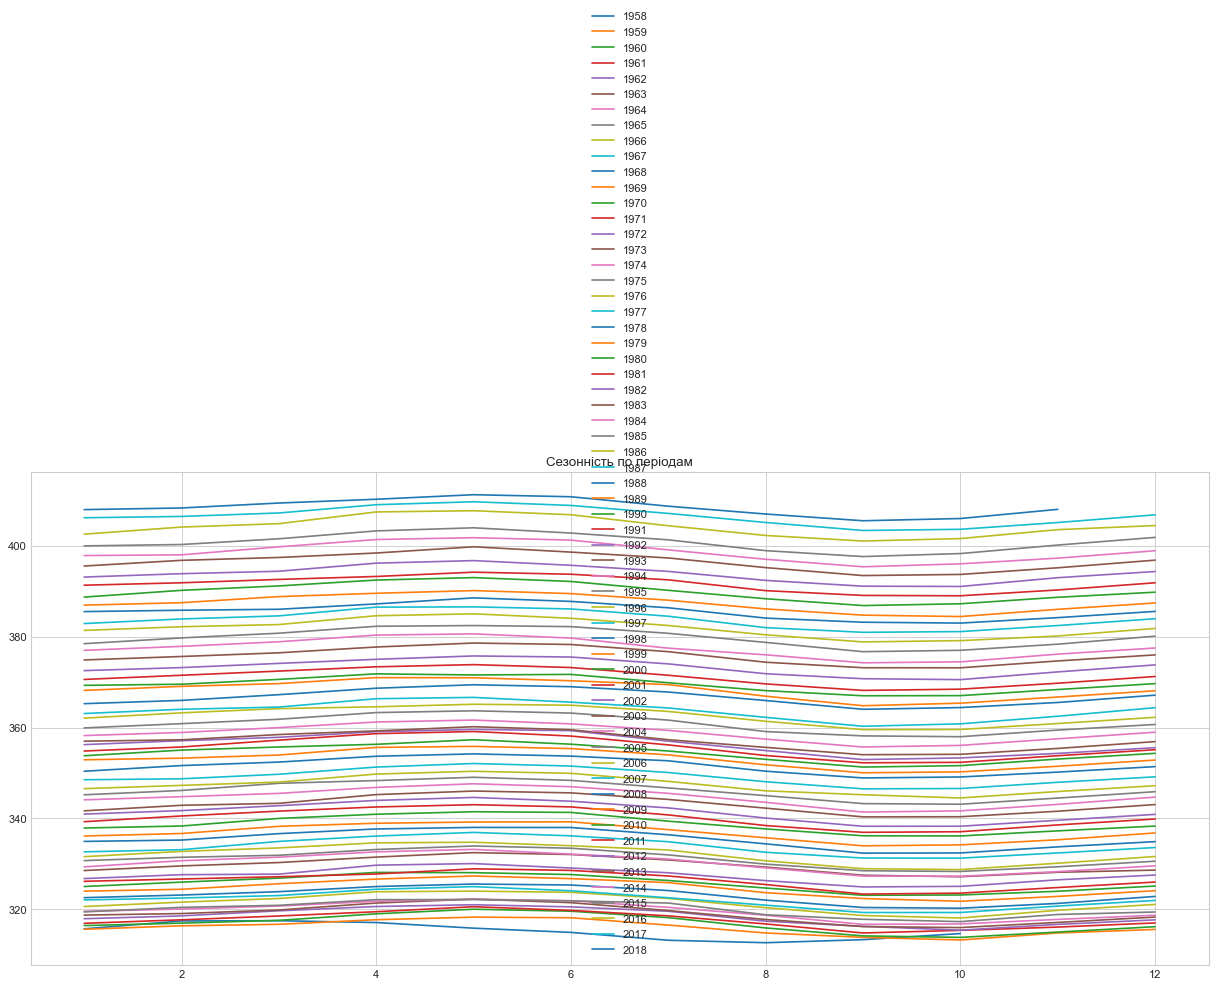

In [17]:
sesonal(df,12)

Text(0.5, 0.98, 'Мультиплікатива модель')

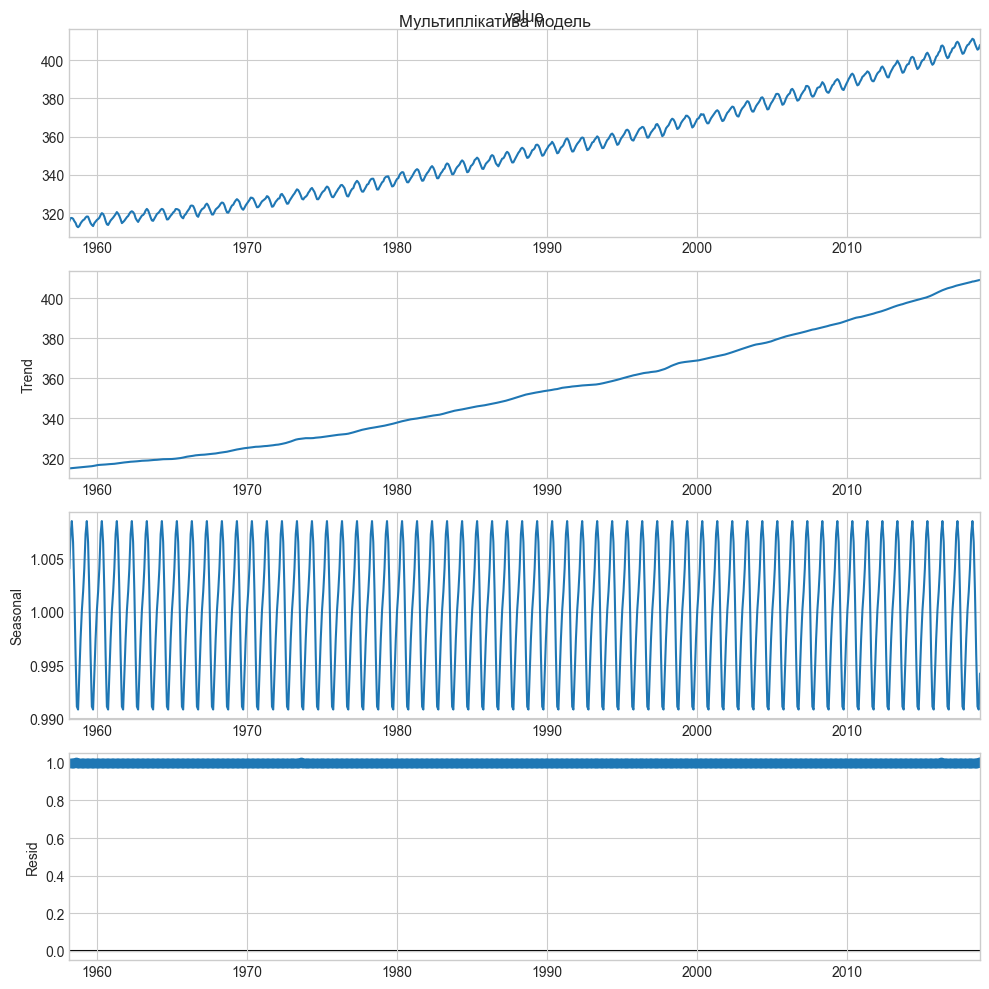

In [19]:
result_M = seasonal_decompose(df.value, model='multiplicative', extrapolate_trend=12)
plt.rcParams.update({'figure.figsize': (10,10)})
result_M.plot().suptitle('Мультиплікатива модель')

In [20]:
df.value['2000']

date
2000-01-01    369.29
2000-02-01    369.54
2000-03-01    370.60
2000-04-01    371.82
2000-05-01    371.58
2000-06-01    371.70
2000-07-01    369.86
2000-08-01    368.13
2000-09-01    367.00
2000-10-01    367.03
2000-11-01    368.37
2000-12-01    369.67
Name: value, dtype: float64

In [21]:
result_M.seasonal['2000']

date
2000-01-01    1.000135
2000-02-01    1.001929
2000-03-01    1.004054
2000-04-01    1.007302
2000-05-01    1.008530
2000-06-01    1.006555
2000-07-01    1.001988
2000-08-01    0.995917
2000-09-01    0.991096
2000-10-01    0.990812
2000-11-01    0.994200
2000-12-01    0.997482
Name: seasonal, dtype: float64

In [22]:
result_M.trend['2000']

date
2000-01-01    368.840417
2000-02-01    368.908750
2000-03-01    369.051250
2000-04-01    369.211667
2000-05-01    369.349583
2000-06-01    369.483750
2000-07-01    369.603333
2000-08-01    369.739583
2000-09-01    369.897917
2000-10-01    370.038750
2000-11-01    370.197917
2000-12-01    370.355417
Name: trend, dtype: float64

Text(0.5, 0.98, 'Адитивная модель')

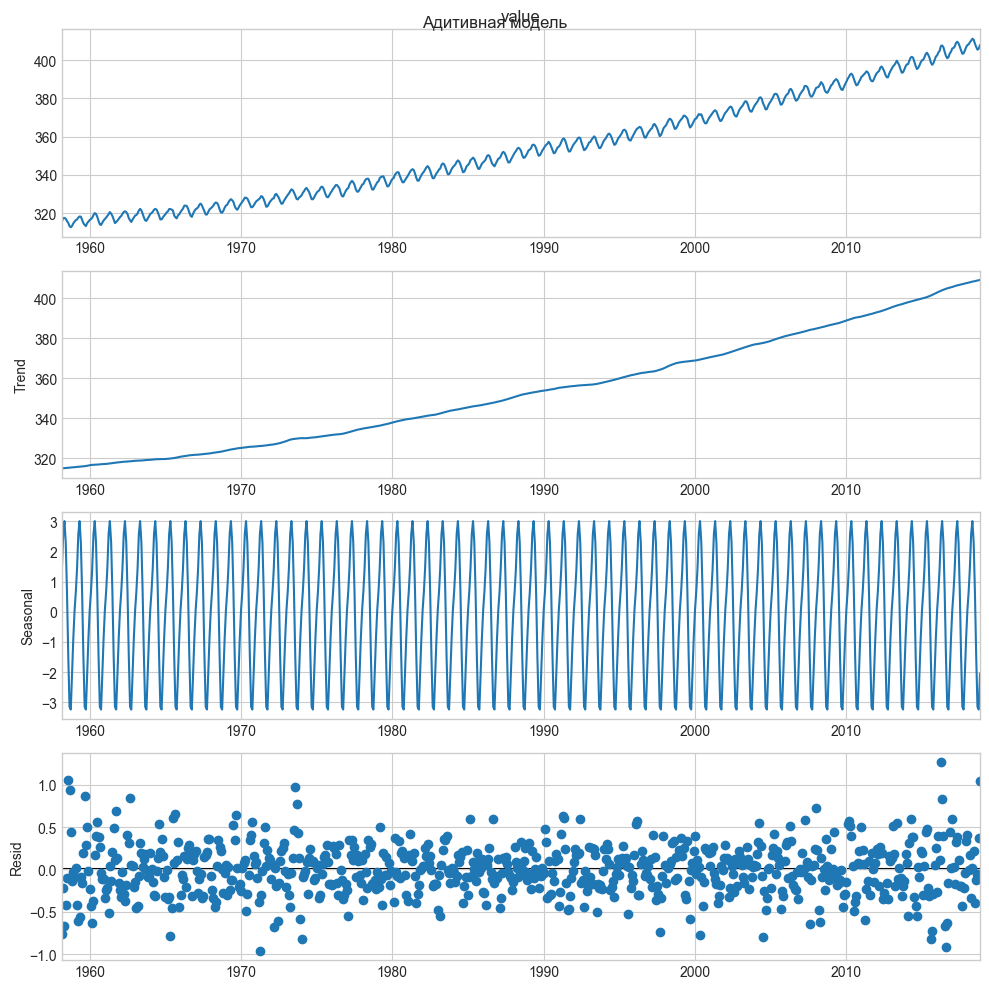

In [23]:
result_A = seasonal_decompose(df.value, model='additive', extrapolate_trend=12)
plt.rcParams.update({'figure.figsize': (10,10)})
result_A.plot().suptitle('Адитивная модель')

In [24]:
result_A.seasonal['2000']

date
2000-01-01    0.059289
2000-02-01    0.688213
2000-03-01    1.435042
2000-04-01    2.579879
2000-05-01    3.010959
2000-06-01    2.308198
2000-07-01    0.687431
2000-08-01   -1.456150
2000-09-01   -3.152087
2000-10-01   -3.241776
2000-11-01   -2.041328
2000-12-01   -0.877669
Name: seasonal, dtype: float64

In [25]:
result_M.seasonal['2000']

date
2000-01-01    1.000135
2000-02-01    1.001929
2000-03-01    1.004054
2000-04-01    1.007302
2000-05-01    1.008530
2000-06-01    1.006555
2000-07-01    1.001988
2000-08-01    0.995917
2000-09-01    0.991096
2000-10-01    0.990812
2000-11-01    0.994200
2000-12-01    0.997482
Name: seasonal, dtype: float64

In [26]:
anomalies[anomalies]

date
1958-03-01    True
1958-08-01    True
1958-09-01    True
1958-10-01    True
1958-11-01    True
1958-12-01    True
1959-01-01    True
1959-08-01    True
1959-09-01    True
1959-10-01    True
1959-11-01    True
1959-12-01    True
1960-09-01    True
1960-10-01    True
1960-11-01    True
1961-09-01    True
1961-10-01    True
1962-10-01    True
1972-05-01    True
1973-03-01    True
1976-11-01    True
1994-04-01    True
1994-05-01    True
1995-03-01    True
1995-07-01    True
1996-01-01    True
1996-08-01    True
1996-11-01    True
1997-11-01    True
2017-04-01    True
2017-05-01    True
2017-06-01    True
2018-03-01    True
2018-04-01    True
2018-05-01    True
2018-06-01    True
2018-07-01    True
dtype: bool

In [27]:
df.loc['1958-09-01']=df.loc['1959-09-01']
df.loc['1958-10-01']=df.loc['1960-10-01']
df.loc['1958-11-01']=df.loc['1959-11-01']
df.loc['1959-10-01']=df.loc['1960-10-01']

[<Axes: >]

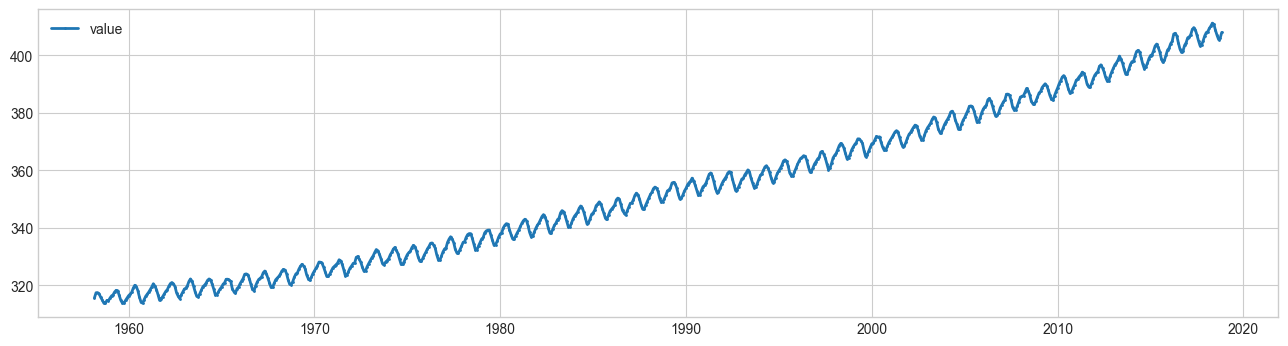

In [28]:
outlier_detector = OutlierDetector(LocalOutlierFactor())
anomalies = outlier_detector.fit_detect(df)
plot(df, anomaly=anomalies, ts_linewidth=2, anomaly_color='red', anomaly_alpha=0.3, curve_group='all')

In [29]:
df

,value
date,
1958-03-01,315.71
1958-04-01,317.45
1958-05-01,317.50
1958-06-01,317.10
1958-07-01,315.86
...,...
2018-07-01,408.71
2018-08-01,406.99
2018-09-01,405.51


In [30]:
train=df['1958':'2010']
train

,value
date,
1958-03-01,315.71
1958-04-01,317.45
1958-05-01,317.50
1958-06-01,317.10
1958-07-01,315.86
...,...
2010-08-01,388.35
2010-09-01,386.85
2010-10-01,387.24


In [31]:
test=df['2010':'2018']
test

,value
date,
2010-01-01,388.71
2010-02-01,390.20
2010-03-01,391.17
2010-04-01,392.46
2010-05-01,393.00
...,...
2018-07-01,408.71
2018-08-01,406.99
2018-09-01,405.51


# Модель Хольта-Вінтерса

In [32]:
fit1 = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='mul').fit()

In [33]:
fit1.params

{'smoothing_level': 0.717832716779275,
 'smoothing_trend': 0.009237751951859476,
 'smoothing_seasonal': 7.009867977120105e-18,
 'damping_trend': nan,
 'initial_level': 316.2747060963163,
 'initial_trend': 0.08505626833225315,
 'initial_seasons': array([0.99842157, 1.00161853, 1.0027885 , 1.00088698, 0.99635085,
        0.99027439, 0.98543971, 0.98515755, 0.98846683, 0.99173594,
        0.99439369, 0.9962649 ]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [34]:
fit1.fittedvalues

date
1958-03-01    315.860409
1958-04-01    316.847678
1958-05-01    317.738946
1958-06-01    317.051782
1958-07-01    315.735792
                 ...    
2010-08-01    388.087748
2010-09-01    386.533666
2010-10-01    386.805342
2010-11-01    388.576489
2010-12-01    390.088857
Length: 634, dtype: float64

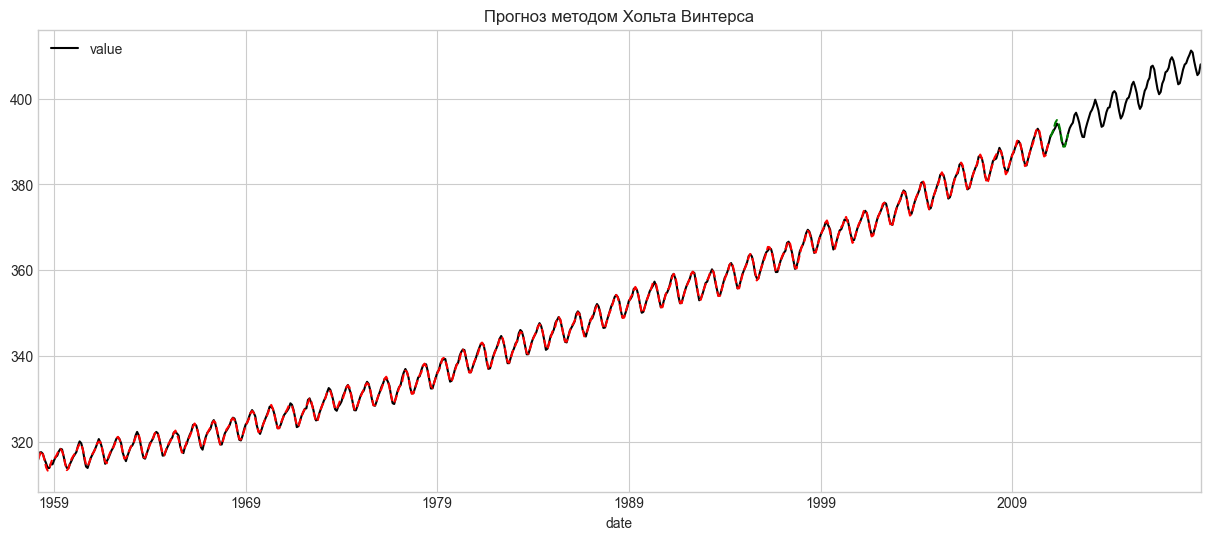

In [35]:
ax = df.plot(figsize=(15,6), color='black', title="Прогноз методом Хольта Винтерса" )
fit1.fittedvalues.plot(ax=ax, style='--', color='red')
fit1.forecast(12).plot(ax=ax, style='--', color='green')
plt.show()

In [36]:
metrics(train, fit1.fittedvalues)

Тест на стаціонарність:
	T-статистика = -6.848
	P-значення = 0.000
Критичне значення :
	1%: -3.4410277306083668 - Дані  стационарні з ймовірністю 99% відсотків
	5%: -2.8662510413264357 - Дані  стационарні з ймовірністю 95% відсотків
	10%: -2.569278890210853 - Дані  стационарні з ймовірністю 90% відсотків
MAD: 0.2322
MSE: 0.09
MAPE: 0.0007
MPE: 0.0
Стандартна похибка: 0.3


In [38]:
metrics(test, fit1.forecast(len(test)))

Тест на стаціонарність:
	T-статистика = -0.364
	P-значення = 0.916
Критичне значення :
	1%: -3.4942202045135513 - Дані не стационарні з ймовірністю 99% відсотків
	5%: -2.889485291005291 - Дані не стационарні з ймовірністю 95% відсотків
	10%: -2.5816762131519275 - Дані не стационарні з ймовірністю 90% відсотків
MAD: 1.3734
MSE: 2.2995
MAPE: 0.0035
MPE: -0.0015
Стандартна похибка: 1.5164


# Модель ARIMA

In [39]:
model = auto_arima(train, seasonal=True, m=12, trace=True, suppress_warnings=True, error_action='ignore', stepwise=True)
model

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=425.067, Time=6.97 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2037.464, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=2.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1355.973, Time=1.00 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2041.397, Time=0.15 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=916.708, Time=5.46 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=637.846, Time=4.60 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=435.612, Time=16.24 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=469.619, Time=15.67 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=1207.577, Time=1.89 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=inf, Time=15.92 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=512.214, Time=16.25 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=408.828, Time=20.36 sec
 ARIMA(1,1,2)(2,0,2)[12] intercept   : AIC=394.769, Time=17.40 sec
 ARIMA(1,1,2)(1,0,2)[12] interc

ARIMA(order=(2, 1, 1), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [40]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(1, 0, 0),
                                seasonal_order=(2, 0, 0, 12))

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9996      0.001    948.834      0.000       0.998       1.002
ar.S.L12       0.5237      0.035     15.178      0.000       0.456       0.591
ar.S.L24       0.4412      0.034     12.858      0.000       0.374       0.508
sigma2         0.1364      0.007     18.614      0.000       0.122       0.151


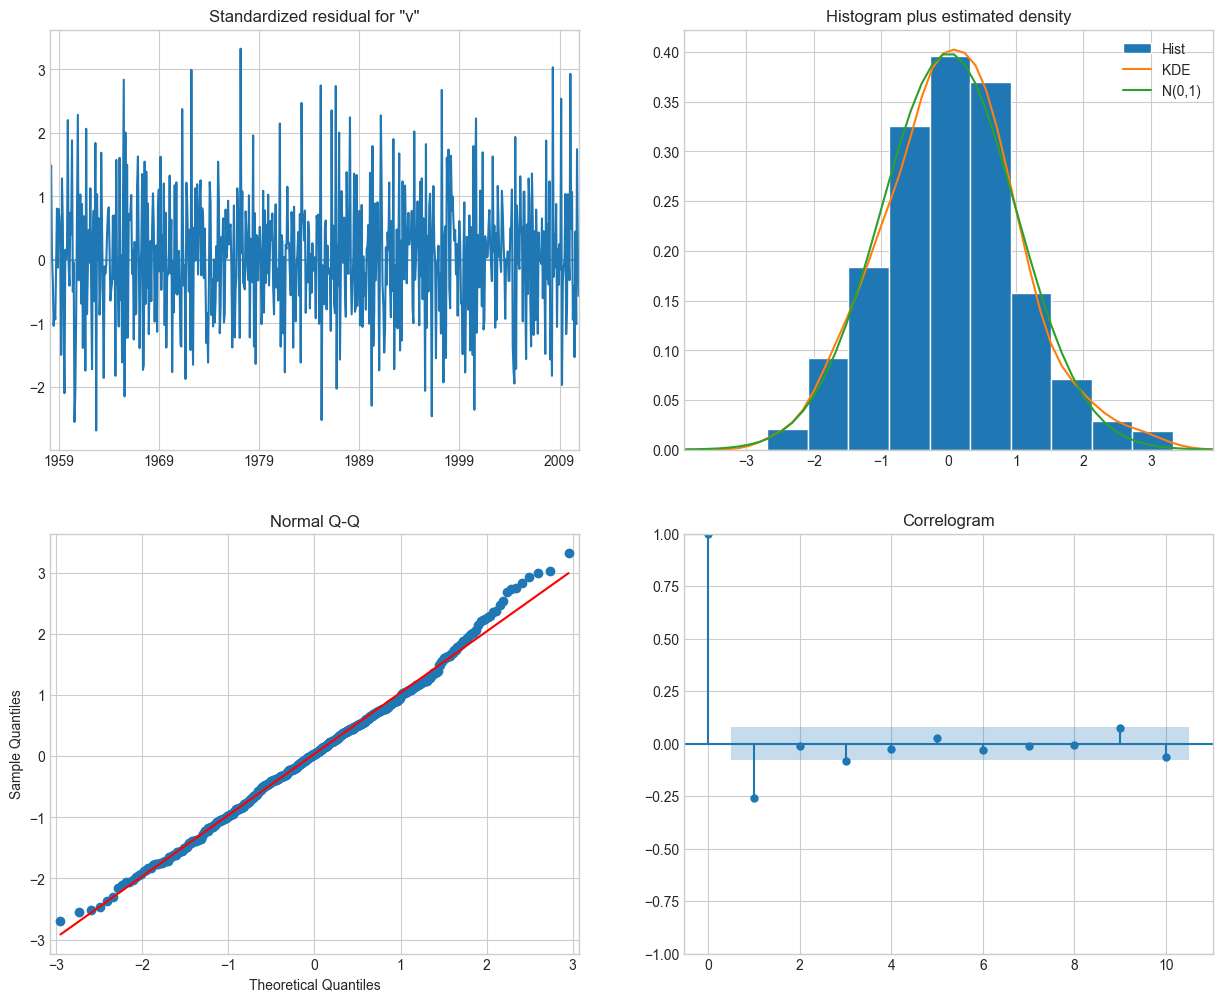

In [41]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [42]:
predict=results.get_prediction()
predict.predicted_mean[:10]

1958-03-01      0.000000
1958-04-01    315.708041
1958-05-01    317.423843
1958-06-01    317.472823
1958-07-01    317.078217
1958-08-01    315.855971
1958-09-01    314.939677
1958-10-01    313.866186
1958-11-01    313.856790
1958-12-01    314.812295
Freq: MS, Name: predicted_mean, dtype: float64

In [43]:
predict=results.get_prediction(start='1958-03-01')
metrics(train['1958-03-01':], predict.predicted_mean)

Тест на стаціонарність:
	T-статистика = -7.497
	P-значення = 0.000
Критичне значення :
	1%: -3.4410627157395908 - Дані  стационарні з ймовірністю 99% відсотків
	5%: -2.8662664495424255 - Дані  стационарні з ймовірністю 95% відсотків
	10%: -2.5692871001333266 - Дані  стационарні з ймовірністю 90% відсотків
MAD: 0.7977
MSE: 157.363
MAPE: 0.0024
MPE: 0.0016
Стандартна похибка: 12.5444


In [44]:
predict=results.get_prediction(start='2018', end='2048')

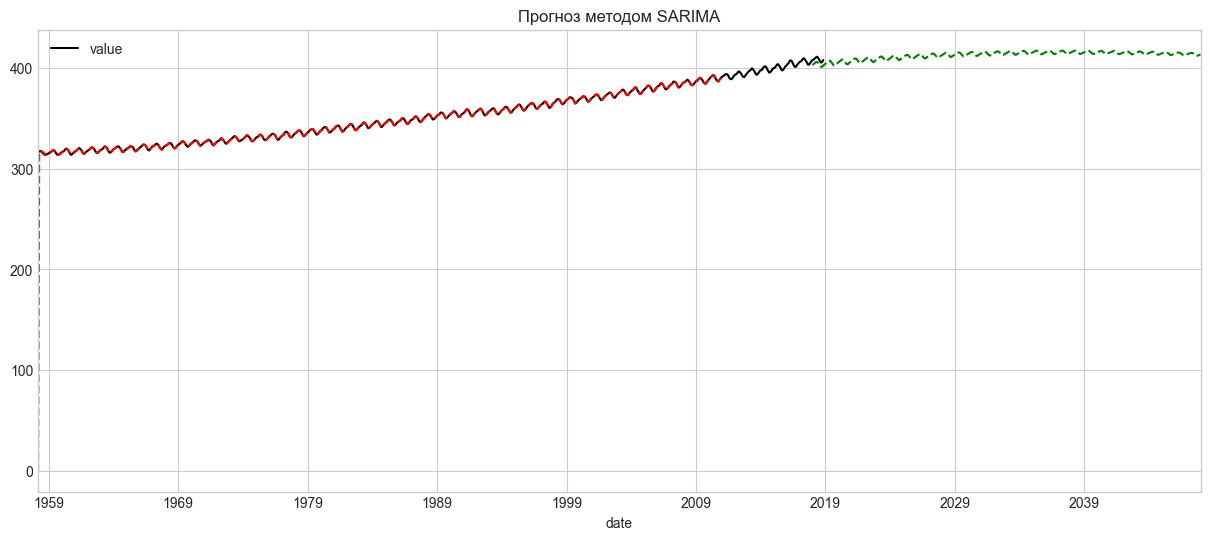

In [45]:
ax = df.plot(figsize=(15,6), color='black', title="Прогноз методом SARIMA" )
results.fittedvalues.plot(ax=ax, style='--', color='red')
predict.predicted_mean.plot(ax=ax, style='--', color='green')
plt.show()

In [46]:
predict=results.get_prediction(start='2010-01-01', end='2018-11-01')
metrics(test, predict.predicted_mean)

Тест на стаціонарність:
	T-статистика = 0.368
	P-значення = 0.980
Критичне значення :
	1%: -3.502704609582561 - Дані не стационарні з ймовірністю 99% відсотків
	5%: -2.8931578098779522 - Дані не стационарні з ймовірністю 95% відсотків
	10%: -2.583636712914788 - Дані не стационарні з ймовірністю 90% відсотків
MAD: 1.8497
MSE: 6.4191
MAPE: 0.0046
MPE: 0.0043
Стандартна похибка: 2.5336


#### Таким чином, виходячи зі значень показників метрики, для прогнозування даних застосуємо модель Хольта-Вінсерта 

In [47]:
df

,value
date,
1958-03-01,315.71
1958-04-01,317.45
1958-05-01,317.50
1958-06-01,317.10
1958-07-01,315.86
...,...
2018-07-01,408.71
2018-08-01,406.99
2018-09-01,405.51


In [48]:
fit1 = ExponentialSmoothing(df, seasonal_periods=12, trend='add', seasonal='mul').fit()

In [49]:
fit1.params

{'smoothing_level': 0.6472041555360878,
 'smoothing_trend': 0.011710534598715072,
 'smoothing_seasonal': 0.05112832653425424,
 'damping_trend': nan,
 'initial_level': 316.7994750468144,
 'initial_trend': 0.07968617309682662,
 'initial_seasons': array([0.99680434, 1.0001012 , 1.0014269 , 0.99968196, 0.99549208,
        0.98956821, 0.98476419, 0.98427038, 0.98763149, 0.990495  ,
        0.9930411 , 0.99486427]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [50]:
fit1.fittedvalues

date
1958-03-01    315.866525
1958-04-01    316.888095
1958-05-01    317.755172
1958-06-01    317.117436
1958-07-01    315.857420
                 ...    
2018-07-01    409.058116
2018-08-01    406.661945
2018-09-01    405.254451
2018-10-01    405.535974
2018-11-01    407.316485
Length: 729, dtype: float64

In [51]:
prediction = fit1.forecast(360)
prediction

2018-12-01    409.270886
2019-01-01    410.502963
2019-02-01    411.320442
2019-03-01    412.367229
2019-04-01    413.905224
                 ...    
2048-07-01    479.511614
2048-08-01    476.988240
2048-09-01    475.064677
2048-10-01    475.190723
2048-11-01    476.869425
Freq: MS, Length: 360, dtype: float64

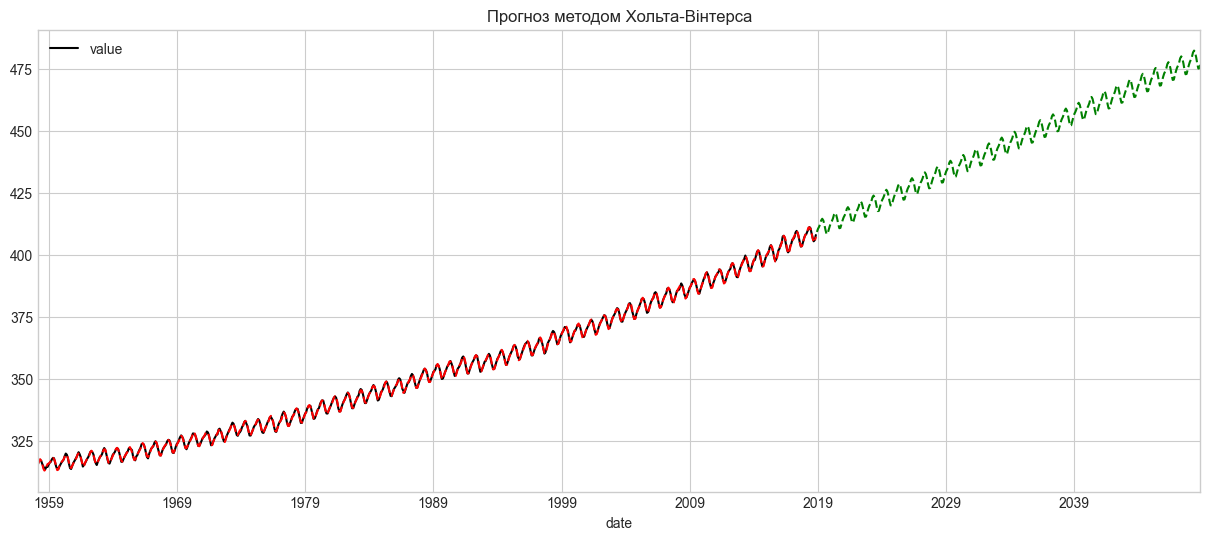

In [58]:
ax = df.plot(figsize=(15,6), color='black', title="Прогноз методом Хольта-Вінтерса" )
fit1.fittedvalues.plot(ax=ax, style='--', color='red')
fit1.forecast(360).plot(ax=ax, style='--', color='green')
plt.show()

In [59]:
prediction.to_csv('prediction.csv')

In [60]:
df1=pd.read_csv("prediction.csv")
df1

,Unnamed: 0,0
0,2018-12-01,409.270886
1,2019-01-01,410.502963
2,2019-02-01,411.320442
3,2019-03-01,412.367229
4,2019-04-01,413.905224
...,...,...
355,2048-07-01,479.511614
356,2048-08-01,476.988240
357,2048-09-01,475.064677
358,2048-10-01,475.190723
